LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime as dt


import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

GET DATA ~ IMPORT NETTING / IMPORT ESTIMATED

In [2]:



# Veri okuma ve işleme fonksiyonları
def getdata(path):
    data = pd.read_csv(path)
    data['PROFILEDATE'] = pd.to_datetime(data['PROFILEDATE'].astype('str'), format ='%Y%m%d%H%M%S')
    return data[['POINTSERNO', 'PROFILEDATE', 'IMPORTNETTING']].reset_index(drop=True)

def getdata_e(path):
    data = pd.read_csv(path)
    data['PROFILEDATE'] = pd.to_datetime(data['PROFILEDATE'].astype('str'), format ='%Y%m%d%H%M%S')
    return data[['POINTSERNO', 'PROFILEDATE', 'IMPORTESTIMATED']].reset_index(drop=True)

In [3]:
# Veriyi okuma
tic_ag = getdata(r'C:\Users\ASUS\Ticarethane_AG\faz2_tic_ag.csv')
tic_ag_e = getdata_e(r'C:\Users\ASUS\Ticarethane_AG\faz2_tic_ag.csv')


Main DataFrame (December 1 - January 31)

In [4]:
def create_pivot_table(dataframe):
    pivot_table = dataframe.pivot_table(
        values='IMPORTNETTING',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, '2023-12-01':'2024-01-31']
    selected_dates = selected_dates.dropna(how='any')
        
    if (selected_dates.isna().sum().sum()) == 0:
        print('There is no nan values and we can continue to the next step')
    else:
        print('There are nan values in the dataset, please check the data')
    return(selected_dates)



r_ = create_pivot_table(tic_ag)

melt_df = r_.reset_index().melt(id_vars='POINTSERNO', var_name='Date', value_name='Value')
melt_df.sort_values('Date', inplace=True)

df_pivoted = melt_df.pivot(index='Date', columns='POINTSERNO', values='Value')

checkpoint1 = df_pivoted.isna().sum().sum()

assert checkpoint1 == 0 , f'df_pivot has NaN'

df_pivoted = df_pivoted.loc[:, df_pivoted.sum(axis=0) != 0]

unique_columns = df_pivoted.apply(lambda x: x.nunique() == 1)

columns_to_drop = unique_columns[unique_columns].index.tolist()

# Drop these columns from the DataFrame
df_main= df_pivoted.drop(columns=columns_to_drop)# df_main benim ana datasetim.. Aralık ve Ocağı verip şubatı tahmin ettireceğim

There is no nan values and we can continue to the next step


February---> For Common Columns

In [5]:
def create_pivot_table(dataframe):
    pivot_table = dataframe.pivot_table(
        values='IMPORTNETTING',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, '2024-02-29':'2024-02-29']
    selected_dates = selected_dates.dropna(how='any')
        
    if (selected_dates.isna().sum().sum()) == 0:
        print('There is no nan values and we can continue to the next step')
    else:
        print('There are nan values in the dataset, please check the data')
    return(selected_dates)



r_ = create_pivot_table(tic_ag)

melt_df = r_.reset_index().melt(id_vars='POINTSERNO', var_name='Date', value_name='Value')
melt_df.sort_values('Date', inplace=True)

df_pivoted = melt_df.pivot(index='Date', columns='POINTSERNO', values='Value')

checkpoint1 = df_pivoted.isna().sum().sum()

assert checkpoint1 == 0 , f'df_pivot has NaN'

df_pivoted = df_pivoted.loc[:, df_pivoted.sum(axis=0) != 0]

unique_columns = df_pivoted.apply(lambda x: x.nunique() == 1)

columns_to_drop = unique_columns[unique_columns].index.tolist()

# Drop these columns from the DataFrame
df_feb= df_pivoted.drop(columns=columns_to_drop)# df_main benim ana datasetim.. Aralık ve Ocağı verip şubatı tahmin ettireceğim

There is no nan values and we can continue to the next step


In [6]:
common_columns = df_main.columns.intersection(df_feb.columns)
df_main = df_main[common_columns]

workframe = df_main.copy()#We'll add categoric futures to df_main.. That's why we need a copy


For Getting Actual Values

In [7]:
def create_pivot_table_for_compare(dataframe,date):
    pivot_table = dataframe.pivot_table(
        values='IMPORTNETTING',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, date:date]
    selected_dates = selected_dates.dropna(how='any')
        
    
    return(selected_dates)


def comparedf (dataframe,date):
    r_ = create_pivot_table_for_compare(dataframe,date)

    melt_df = r_.reset_index().melt(id_vars='POINTSERNO', var_name='Date', value_name='Value')
    melt_df.sort_values('Date', inplace=True)

    df_pivoted = melt_df.pivot(index='Date', columns='POINTSERNO', values='Value')

    checkpoint1 = df_pivoted.isna().sum().sum()

    assert checkpoint1 == 0 , f'df_pivot has NaN'

    #df_pivoted = df_pivoted.loc[:, df_pivoted.sum(axis=0) != 0]

    # unique_columns = df_pivoted.apply(lambda x: x.nunique() == 1)

    # columns_to_drop = unique_columns[unique_columns].index.tolist()

    # # Drop these columns from the DataFrame
    # df_act= df_pivoted.drop(columns=columns_to_drop)# df_main benim ana datasetim.. Aralık ve Ocağı verip şubatı tahmin ettireceğim
    df_act = df_pivoted
    return df_act

Adding Categorical Features

In [8]:
def create_features(df, label=None):
    """
    Create time series features based on time series index.
    """
    df['date'] = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label is not None:
        y = df[label]
        return X, y
    return X

In [9]:
from tqdm import tqdm ## Watch out for process

Actual Values

In [10]:
def create_pivot_table(dataframe):
    pivot_table = dataframe.pivot_table(
        values='IMPORTNETTING',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, '2024-02-01':'2024-02-29']
    selected_dates = selected_dates.dropna(how='any')
        
    if (selected_dates.isna().sum().sum()) == 0:
        print('There is no nan values and we can continue to the next step')
    else:
        print('There are nan values in the dataset, please check the data')
    return(selected_dates)



r_ = create_pivot_table(tic_ag)

melt_df = r_.reset_index().melt(id_vars='POINTSERNO', var_name='Date', value_name='Value')
melt_df.sort_values('Date', inplace=True)

df_pivoted = melt_df.pivot(index='Date', columns='POINTSERNO', values='Value')

checkpoint1 = df_pivoted.isna().sum().sum()

assert checkpoint1 == 0 , f'df_pivot has NaN'

df_pivoted = df_pivoted.loc[:, df_pivoted.sum(axis=0) != 0]

unique_columns = df_pivoted.apply(lambda x: x.nunique() == 1)

columns_to_drop = unique_columns[unique_columns].index.tolist()

# Drop these columns from the DataFrame
df_justfeb= df_pivoted.drop(columns=columns_to_drop)# df_main benim ana datasetim.. Aralık ve Ocağı verip şubatı tahmin ettireceğim

There is no nan values and we can continue to the next step


In [11]:
df_justfeb = df_justfeb[common_columns]

ITTERATIVE MODEL ~~55-60 min

In [12]:
##111
# Initialize an empty DataFrame to store all predictions
all_pred = pd.DataFrame()

for column in tqdm(workframe.columns):
    if column != 'date':  # 'date' sütununu işleme sokmayacağız
        eachCol = workframe[[column]]

        column_pred = pd.DataFrame()

        for i in range(29):
            X_train, y_train = create_features(eachCol, label=column)
            
            reg = xgb.XGBRegressor(n_estimators=1000)
            reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train)],
                    early_stopping_rounds=50,
                    verbose=False)
        
            need = X_train[-24:]
            # Tahminler yapma
            pred = reg.predict(need)
            new_index = need.index + pd.DateOffset(days=1)
            pred = pd.Series(pred, index=new_index)
            
            if i == 0:
                column_pred = pred.copy()
            
            else:
                column_pred = pd.concat([column_pred, pred], ignore_index=False)
            
            # Get the actual data for the last prediction date
            compare_date = pred.index[-1].strftime('%Y-%m-%d')
            
            try:
                actual_data_for_day = comparedf(tic_ag, compare_date)[[column]]
                eachCol = pd.concat([eachCol, actual_data_for_day], ignore_index=False)
            except KeyError as e:
                print(f"An error occurred: {e} - Column: {column} on Date: {compare_date}")
                actual_data_for_day = pred.copy()
                eachCol = pd.concat([eachCol, actual_data_for_day], ignore_index=False)
            except Exception as e:
                print(f"An error occurred: {e} - Column: {column} on Date: {compare_date}")
                actual_data_for_day = pred.copy()
                eachCol = pd.concat([eachCol, actual_data_for_day], ignore_index=False)

        # Add the predictions for the current column to the all_pred DataFrame
        all_pred = pd.concat([all_pred, column_pred], axis=1)
        
        

# Print or save the all_pred DataFrame
all_pred


100%|██████████| 217/217 [52:17<00:00, 14.46s/it] 


,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-02-01 00:00:00,0.096705,0.030268,0.101760,0.086979,0.257421,0.021014,0.252696,0.030948,0.002006,0.116525,...,0.018911,0.016111,0.009459,0.013701,0.004230,0.000076,0.003648,0.006443,0.003688,0.036039
2024-02-01 01:00:00,0.096948,0.030069,0.102374,0.096842,0.256913,0.021332,0.244101,0.030973,0.002006,0.113248,...,0.018911,0.006631,0.009459,0.007518,0.004230,0.000076,0.003648,0.006487,0.003564,0.050438
2024-02-01 02:00:00,0.096948,0.029972,0.105452,0.088441,0.264720,0.021332,0.228416,0.031148,0.002006,0.112859,...,0.018911,0.004219,0.009459,0.064793,0.004230,0.000076,0.003648,0.007190,0.003564,0.049238
2024-02-01 03:00:00,0.096948,0.029846,0.115559,0.094770,0.265384,0.020766,0.228831,0.031675,0.001774,0.109813,...,0.019015,0.003205,0.009459,0.037598,0.004230,0.000076,0.007206,0.006958,0.003564,0.034512
2024-02-01 04:00:00,0.097856,0.030507,0.129993,0.088266,0.264691,0.020621,0.237563,0.032877,0.001774,0.109427,...,0.019015,0.003104,0.009443,0.008016,0.004230,0.000076,0.012308,0.006058,0.003564,0.033015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,0.142831,0.055747,0.099793,0.083154,0.241723,0.037500,0.211654,0.022044,0.001138,0.136298,...,0.011320,0.022927,0.025230,0.030639,0.011900,0.005893,0.005012,0.013464,0.004828,0.033731
2024-02-29 20:00:00,0.120091,0.060733,0.095396,0.078296,0.245640,0.033772,0.205820,0.017900,0.001138,0.134554,...,0.011297,0.023271,0.022325,0.033904,0.011201,0.003237,0.004873,0.013204,0.004860,0.056083
2024-02-29 21:00:00,0.113197,0.045869,0.091442,0.087044,0.245782,0.027397,0.212701,0.018501,0.001138,0.134051,...,0.011297,0.023271,0.017211,0.030179,0.009769,0.003160,0.004580,0.013204,0.004860,0.054751
2024-02-29 22:00:00,0.112729,0.040211,0.088955,0.077991,0.248782,0.023197,0.200424,0.018567,0.001138,0.132848,...,0.011230,0.020697,0.009665,0.033847,0.006001,0.003160,0.004391,0.012613,0.004583,0.059720


In [13]:
all_pred.columns = workframe.columns
all_pred

POINTSERNO,5318,5436,5441,5586,5682,5684,5685,5968,6004,6027,...,277840,299331,319240,320016,320345,320437,320650,320876,342972,343618
2024-02-01 00:00:00,0.096705,0.030268,0.101760,0.086979,0.257421,0.021014,0.252696,0.030948,0.002006,0.116525,...,0.018911,0.016111,0.009459,0.013701,0.004230,0.000076,0.003648,0.006443,0.003688,0.036039
2024-02-01 01:00:00,0.096948,0.030069,0.102374,0.096842,0.256913,0.021332,0.244101,0.030973,0.002006,0.113248,...,0.018911,0.006631,0.009459,0.007518,0.004230,0.000076,0.003648,0.006487,0.003564,0.050438
2024-02-01 02:00:00,0.096948,0.029972,0.105452,0.088441,0.264720,0.021332,0.228416,0.031148,0.002006,0.112859,...,0.018911,0.004219,0.009459,0.064793,0.004230,0.000076,0.003648,0.007190,0.003564,0.049238
2024-02-01 03:00:00,0.096948,0.029846,0.115559,0.094770,0.265384,0.020766,0.228831,0.031675,0.001774,0.109813,...,0.019015,0.003205,0.009459,0.037598,0.004230,0.000076,0.007206,0.006958,0.003564,0.034512
2024-02-01 04:00:00,0.097856,0.030507,0.129993,0.088266,0.264691,0.020621,0.237563,0.032877,0.001774,0.109427,...,0.019015,0.003104,0.009443,0.008016,0.004230,0.000076,0.012308,0.006058,0.003564,0.033015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,0.142831,0.055747,0.099793,0.083154,0.241723,0.037500,0.211654,0.022044,0.001138,0.136298,...,0.011320,0.022927,0.025230,0.030639,0.011900,0.005893,0.005012,0.013464,0.004828,0.033731
2024-02-29 20:00:00,0.120091,0.060733,0.095396,0.078296,0.245640,0.033772,0.205820,0.017900,0.001138,0.134554,...,0.011297,0.023271,0.022325,0.033904,0.011201,0.003237,0.004873,0.013204,0.004860,0.056083
2024-02-29 21:00:00,0.113197,0.045869,0.091442,0.087044,0.245782,0.027397,0.212701,0.018501,0.001138,0.134051,...,0.011297,0.023271,0.017211,0.030179,0.009769,0.003160,0.004580,0.013204,0.004860,0.054751
2024-02-29 22:00:00,0.112729,0.040211,0.088955,0.077991,0.248782,0.023197,0.200424,0.018567,0.001138,0.132848,...,0.011230,0.020697,0.009665,0.033847,0.006001,0.003160,0.004391,0.012613,0.004583,0.059720


PREDDICTION SUM VS ACTUAL SUM

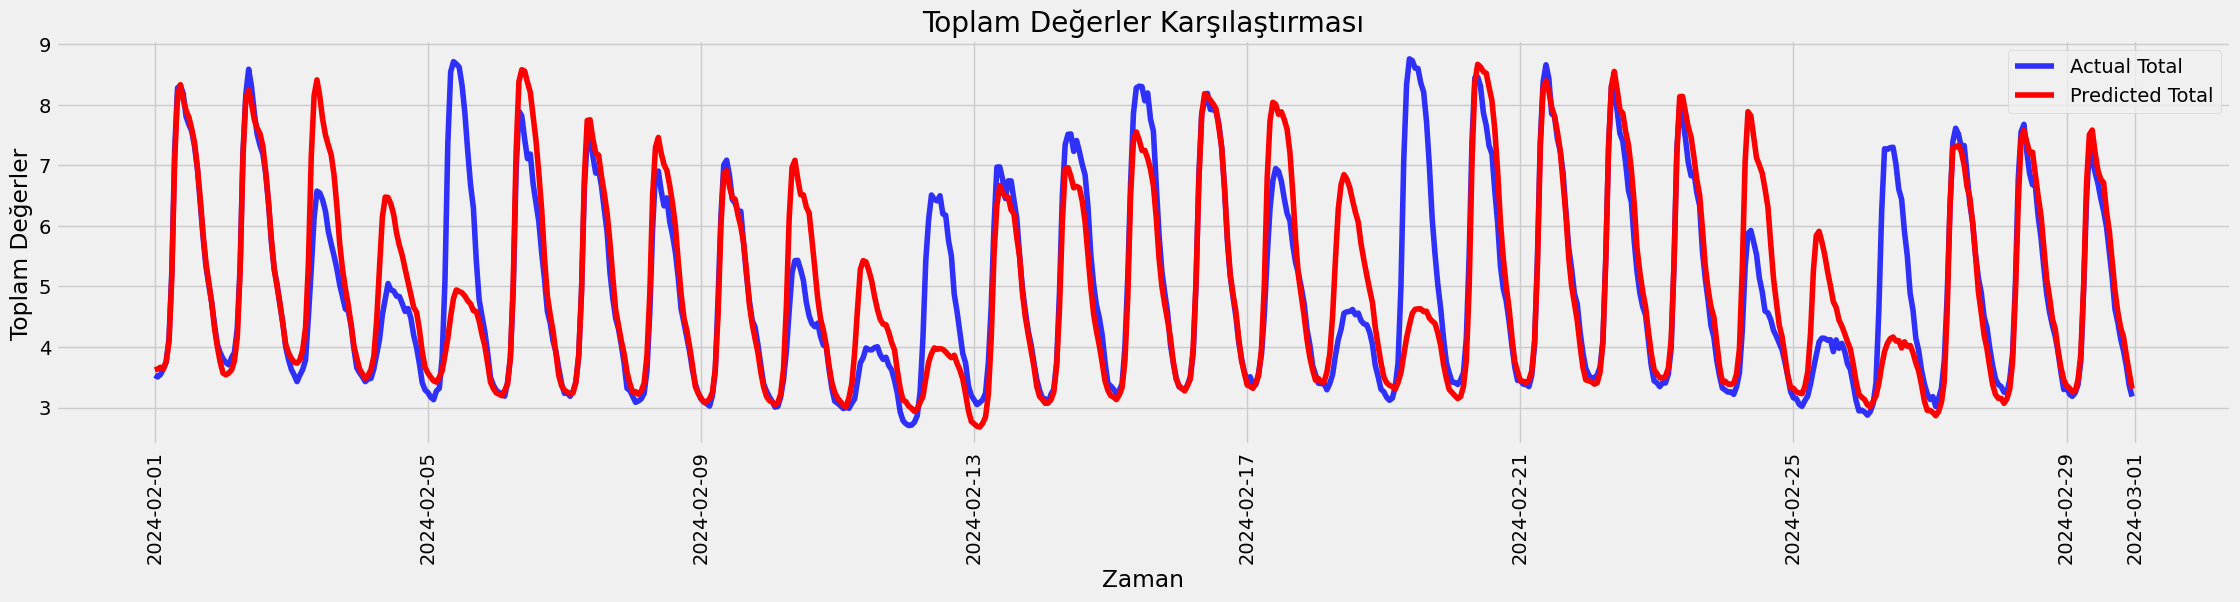

In [19]:
all_pred_sum = all_pred.sum(axis=1)
df_justfeb_sum = df_justfeb.sum(axis=1)

all_pred_sum = all_pred_sum.sort_index()
df_justfeb_sum = df_justfeb_sum.sort_index()


plt.figure(figsize=(25, 5))
plt.plot(df_justfeb_sum.index, df_justfeb_sum.values, label='Actual Total', color='blue', alpha=0.8)  # Gerçek veri toplamları
plt.plot(all_pred_sum.index, all_pred_sum.values, label='Predicted Total', color='red')  # Tahmin edilen veri toplamları

plt.title('Toplam Değerler Karşılaştırması')
plt.xlabel('Zaman')
plt.xticks(rotation=90)
plt.ylabel('Toplam Değerler')
plt.legend()
plt.grid(True)
plt.show()

MATHEMATICAL FORECAST

In [15]:
def create_pivot_table_for_checking_estimated(dataframe):
    pivot_table = dataframe.pivot_table(
        values='IMPORTESTIMATED',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, '2024-02-01':'2024-02-29']
    selected_dates = selected_dates.dropna(how='any')
    
    if (selected_dates.isna().sum().sum()) == 0:
        print('There is no nan values and we can continue to the next step')
    else:
        print('There are nan values in the dataset, please check the data')
    return(selected_dates)

df_pivoted_for_checking_e = create_pivot_table_for_checking_estimated(tic_ag_e)
df_pivoted_for_checking_e = df_pivoted_for_checking_e.transpose()#.reset_index(drop = True)
math = df_pivoted_for_checking_e[common_columns]





There is no nan values and we can continue to the next step


PREDICTION VS ACTUAL VS MATHEMATICAL

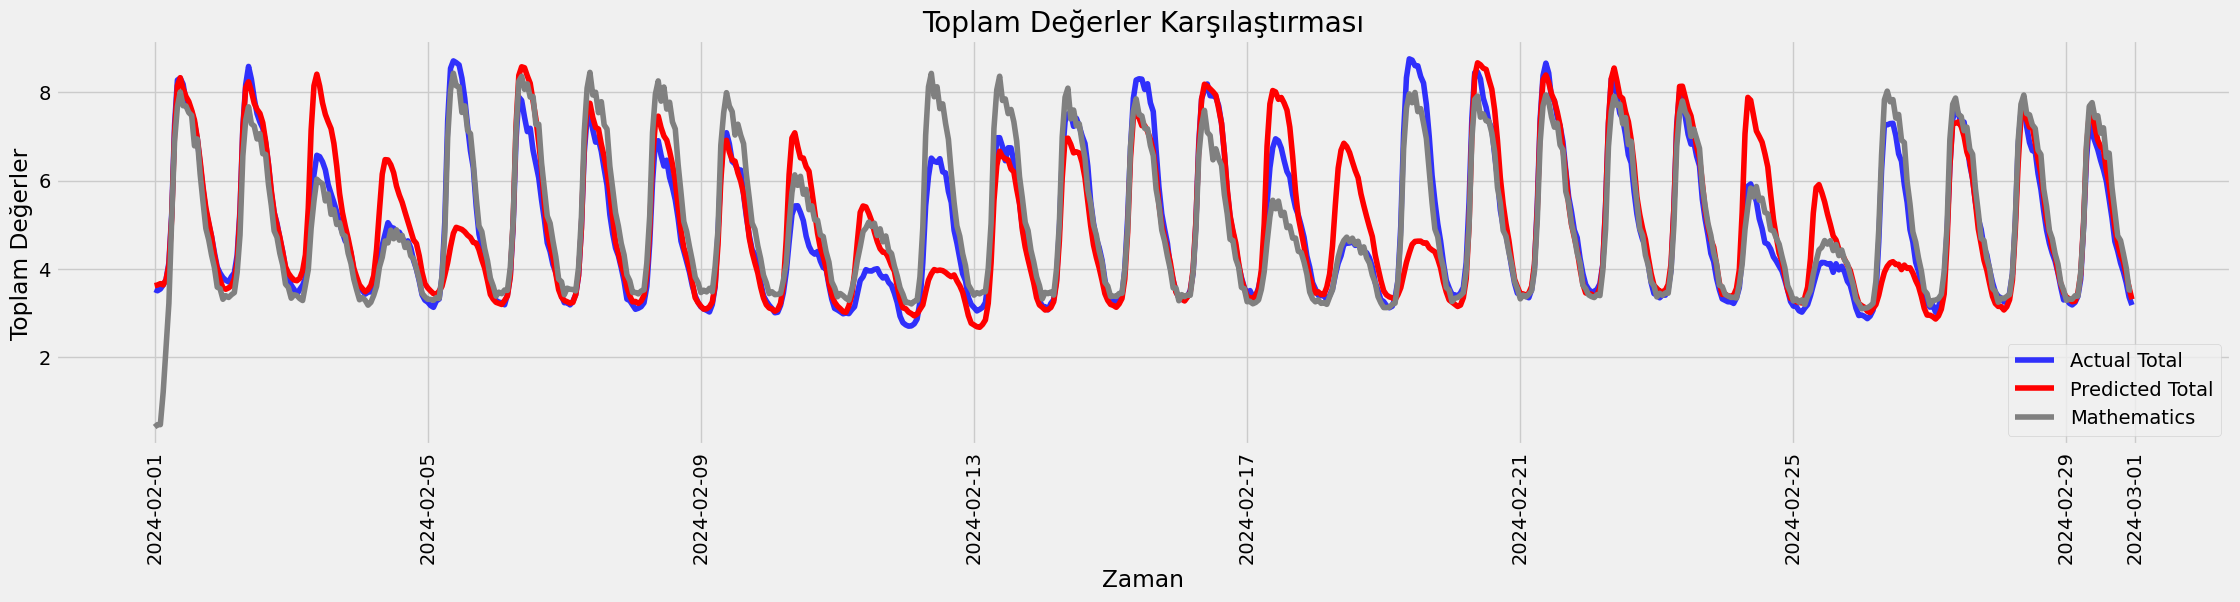

In [20]:
df_justfeb_sum = df_justfeb.sum(axis=1)
all_pred_sum = all_pred.sum(axis=1)
math_sum =math.sum(axis=1)


all_pred_sum = all_pred_sum.sort_index()
df_justfeb_sum = df_justfeb_sum.sort_index()
math_sum = math_sum.sort_index()




# Ortak indeks kısmını kullanarak grafik oluşturalım
plt.figure(figsize=(25, 5))
plt.plot(df_justfeb_sum.index, df_justfeb_sum.values, label='Actual Total', color='blue', alpha=0.8)  # Gerçek veri toplamları
plt.plot(all_pred_sum.index, all_pred_sum.values, label='Predicted Total', color='red')  # Tahmin edilen veri toplamları
plt.plot(math_sum.index, math_sum.values, label='Mathematics', color='grey') # matematik yöntem 

plt.title('Toplam Değerler Karşılaştırması')
plt.xlabel('Zaman')
plt.xticks(rotation=90)
plt.ylabel('Toplam Değerler')
plt.legend()
plt.grid(True)
plt.show()

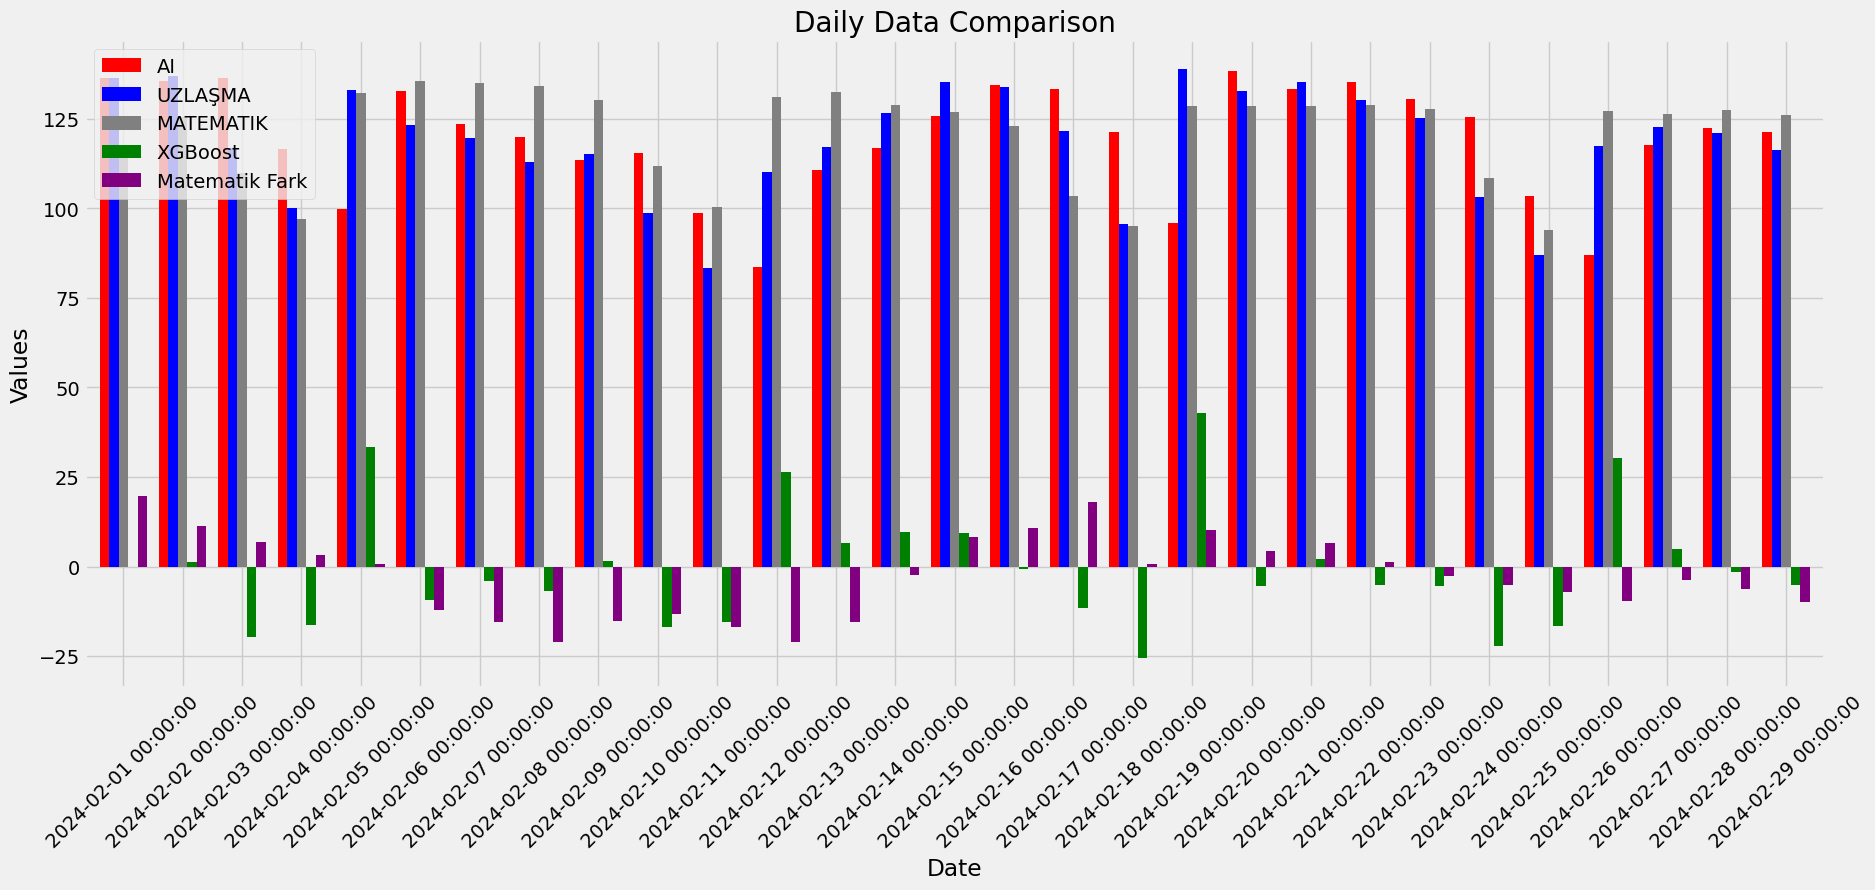

In [21]:
sums_0_24 = all_pred_sum.copy()
sum_1_24 = df_justfeb_sum.copy()
sum_2_24 = math_sum.copy()



sums_0_24.index = pd.to_datetime(sums_0_24.index)#predict
sum_1_24.index = pd.to_datetime(sum_1_24.index)#uzlaşma 
sum_2_24.index = pd.to_datetime(sum_2_24.index)#matematik
 
diff_ac_pc = sum_1_24 - sums_0_24
diff_ac_ec = sum_1_24 - sum_2_24
 
daily_sums_0_24 = sums_0_24.resample('D').sum()
daily_sums_1_24 = sum_1_24.resample('D').sum()
daily_sums_2_24 = sum_2_24.resample('D').sum()
daily_diff_ac_pc = diff_ac_pc.resample('D').sum()
daily_diff_ac_ec = diff_ac_ec.resample('D').sum()
 
data = pd.DataFrame({
    'AI': daily_sums_0_24,
    'UZLAŞMA': daily_sums_1_24,
    'MATEMATIK': daily_sums_2_24,
    'XGBoost': daily_diff_ac_pc,
    'Matematik Fark': daily_diff_ac_ec
})
 
colors = ['red', 'blue','grey',  'green', 'purple']  
 
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))
data.plot(kind='bar', ax=ax, width=0.8, color=colors)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('Daily Data Comparison')
plt.xticks(rotation=45)
plt.show()